<a href="https://colab.research.google.com/github/shrijanpandey/Kobeni/blob/master/SIGNATURE_VERIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from zipfile import ZipFile
file_name = "forged.zip"

with ZipFile(file_name, 'r') as zip:
   zip.extractall()
   print('Done')

Done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from scipy import ndimage
from skimage.measure import regionprops
from skimage import io
from skimage.filters import threshold_otsu
import tensorflow as tf
import pandas as pd
import numpy as np
from time import time
import keras

In [ ]:
genuine_image_paths = "/content/drive/MyDrive/real"
forged_image_paths = "/content/drive/MyDrive/forged"

In [ ]:
genuine_image_paths = "/content/real"
forged_image_paths = "/content/forged"

In [ ]:
def rgbgrey(img):
    # Converts rgb to grayscale
    greyimg = np.zeros((img.shape[0], img.shape[1]))
    for row in range(len(img)):
        for col in range(len(img[row])):
            greyimg[row][col] = np.average(img[row][col])
    return greyimg

In [ ]:
def greybin(img):
    # Converts grayscale to binary
    blur_radius = 0.8
    img = ndimage.gaussian_filter(img, blur_radius)  # to remove small components or noise
    thres = threshold_otsu(img)
    binimg = img > thres
    binimg = np.logical_not(binimg)
    return binimg

In [ ]:
def preproc(path, img=None, display=True):
    if img is None:
        img = mpimg.imread(path)
    if display:
        plt.imshow(img)
        plt.show()
    grey = rgbgrey(img) #rgb to grey
    if display:
        plt.imshow(grey, cmap = matplotlib.cm.Greys_r)
        plt.show()
    binimg = greybin(grey) #grey to binary
    if display:
        plt.imshow(binimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    r, c = np.where(binimg==1)
    signimg = binimg[r.min(): r.max(), c.min(): c.max()]
    if display:
        plt.imshow(signimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    return signimg

In [ ]:
def Ratio(img):
    a = 0
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                a = a+1
    total = img.shape[0] * img.shape[1]
    return a/total

In [ ]:
def Centroid(img):
    numOfWhites = 0
    a = np.array([0,0])
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                b = np.array([row,col])
                a = np.add(a,b)
                numOfWhites += 1
    rowcols = np.array([img.shape[0], img.shape[1]])
    centroid = a/numOfWhites
    centroid = centroid/rowcols
    return centroid[0], centroid[1]

In [ ]:
def EccentricitySolidity(img):
    r = regionprops(img.astype("int8"))
    return r[0].eccentricity, r[0].solidity

In [ ]:
def SkewKurtosis(img):
    h,w = img.shape
    x = range(w)  # cols value
    y = range(h)  # rows value
    #calculate projections along the x and y axes
    xp = np.sum(img,axis=0)
    yp = np.sum(img,axis=1)
    #centroid
    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)
    x2 = (x-cx)**2
    y2 = (y-cy)**2
    sx = np.sqrt(np.sum(x2*xp)/np.sum(img))
    sy = np.sqrt(np.sum(y2*yp)/np.sum(img))

    #skewness
    x3 = (x-cx)**3
    y3 = (y-cy)**3
    skewx = np.sum(xp*x3)/(np.sum(img) * sx**3)
    skewy = np.sum(yp*y3)/(np.sum(img) * sy**3)

    #Kurtosis
    x4 = (x-cx)**4
    y4 = (y-cy)**4
    kurtx = np.sum(xp*x4)/(np.sum(img) * sx**4) - 3
    kurty = np.sum(yp*y4)/(np.sum(img) * sy**4) - 3

    return (skewx , skewy), (kurtx, kurty)

In [ ]:
def getFeatures(path, img=None, display=False):
    if img is None:
        img = mpimg.imread(path)
    img = preproc(path, display=display)
    ratio = Ratio(img)
    centroid = Centroid(img)
    eccentricity, solidity = EccentricitySolidity(img)
    skewness, kurtosis = SkewKurtosis(img)
    retVal = (ratio, centroid, eccentricity, solidity, skewness, kurtosis)
    return retVal

In [ ]:
def getCSVFeatures(path, img=None, display=False):
    if img is None:
        img = mpimg.imread(path)
    temp = getFeatures(path, display=display)
    features = (temp[0], temp[1][0], temp[1][1], temp[2], temp[3], temp[4][0], temp[4][1], temp[5][0], temp[5][1])
    return features

In [ ]:
import os

def makeCSV():
    if not(os.path.exists('/content/Features')):
        os.mkdir('/content/Features')
        print('New folder "Features" created')
    if not(os.path.exists('/content/Features/Training')):
        os.mkdir('/content/Features/Training')
        print('New folder "Features/Training" created')
    if not(os.path.exists('/content/Features/Testing')):
        os.mkdir('/content/Features/Testing')
        print('New folder "/Testing" created')
    # genuine signatures path
    gpath = genuine_image_paths
    # forged signatures path
    fpath = forged_image_paths
    for person in range(1, 16):
        per = ('00'+str(person))[-3:]
        print('Saving features for person id-',per)

        with open('/content/Features/Training/training_'+per+'.csv', 'w') as train_handle:
            train_handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Training set
            for i in range(0,5):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                train_handle.write(','.join(map(str, features))+',1\n')
            for i in range(0,5):
                source = os.path.join(fpath, '021'+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                train_handle.write(','.join(map(str, features))+',0\n')

        with open('/content/Features/Testing/testing_'+per+'.csv', 'w') as test_handle:
            test_handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Testing set
            for i in range(5, 10):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                test_handle.write(','.join(map(str, features))+',1\n')
            for i in range(5,10):
                source = os.path.join(fpath, '021'+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                test_handle.write(','.join(map(str, features))+',0\n')

In [ ]:
makeCSV()

Saving features for person id- 001
Saving features for person id- 002
Saving features for person id- 003
Saving features for person id- 004
Saving features for person id- 005
Saving features for person id- 006
Saving features for person id- 007
Saving features for person id- 008
Saving features for person id- 009
Saving features for person id- 010
Saving features for person id- 011
Saving features for person id- 012
Saving features for person id- 013
Saving features for person id- 014
Saving features for person id- 015


In [ ]:
def testing(path):
    feature = getCSVFeatures(path)
    if not(os.path.exists('/content/TestFeatures')):
        os.mkdir('/content/TestFeatures')
    with open('/content/TestFeatures/testcsv.csv', 'w') as handle:
        handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y\n')
        handle.write(','.join(map(str, feature))+'\n')

Epoch 1: Accuracy = 0.48, Loss = 0.52
Epoch 2: Accuracy = 0.57, Loss = 0.43
Epoch 3: Accuracy = 0.63, Loss = 0.37
Epoch 4: Accuracy = 0.63, Loss = 0.37
Epoch 5: Accuracy = 0.67, Loss = 0.33
Epoch 6: Accuracy = 0.63, Loss = 0.37
Epoch 7: Accuracy = 0.63, Loss = 0.37
Epoch 8: Accuracy = 0.62, Loss = 0.38
Epoch 9: Accuracy = 0.67, Loss = 0.33
Epoch 10: Accuracy = 0.66, Loss = 0.34


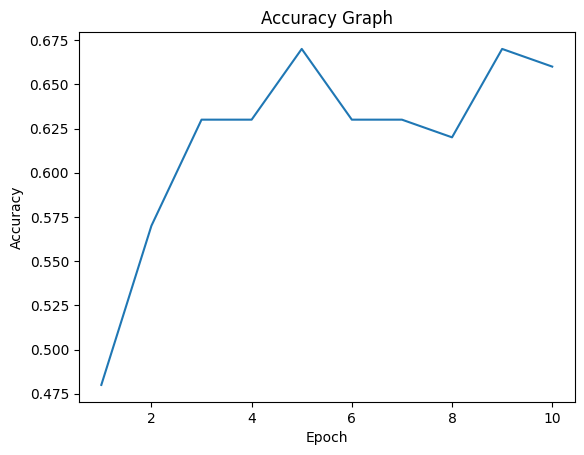

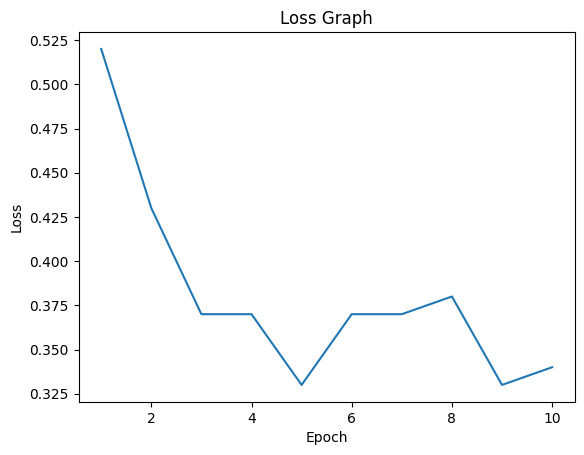

In [ ]:
import random
import matplotlib.pyplot as plt

def generate_dataset(n):
    dataset = []
    for i in range(n):
        x = random.uniform(-10, 10)
        y = random.uniform(-10, 10)
        if x**2 + y**2 <= 25:
            label = 1
        else:
            label = 0
        dataset.append((x, y, label))
    return dataset

def train(dataset, epochs, learning_rate):
    weights = [0, 0, 0]
    accuracies = []
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        for data in dataset:
            x, y, label = data
            weighted_sum = weights[0] * 1 + weights[1] * x + weights[2] * y
            if weighted_sum > 0:
                prediction = 1
            else:
                prediction = 0
            if prediction == label:
                correct += 1
            error = label - prediction
            weights[0] += learning_rate * error * 1
            weights[1] += learning_rate * error * x
            weights[2] += learning_rate * error * y
            total_loss += error ** 2
        accuracy = correct / len(dataset)
        accuracies.append(accuracy)
        loss = total_loss / len(dataset)
        losses.append(loss)
        print(f"Epoch {epoch + 1}: Accuracy = {accuracy}, Loss = {loss}")
    plt.plot(range(1, epochs+1), accuracies)
    plt.title('Accuracy Graph')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    plt.plot(range(1, epochs+1), losses)
    plt.title('Loss Graph')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    return weights, accuracies[-1]

if __name__ == '__main__':
    dataset = generate_dataset(100)
    weights, accuracy = train(dataset, 10, 0.1)


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])